### Прогнозирование уровня средней заработной платы в России

In [3]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

Populating the interactive namespace from numpy and matplotlib


In [10]:
def invboxcox(y,lmbda):
    '''Преобразование обратное преобразованию Бокса-Кокса'''
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

##### 1. Импорт и обзор данных

In [5]:
data = pd.read_csv('WAG_C_M.csv', sep=';', index_col=['month'], parse_dates=['month'], dayfirst=True)

In [7]:
data.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


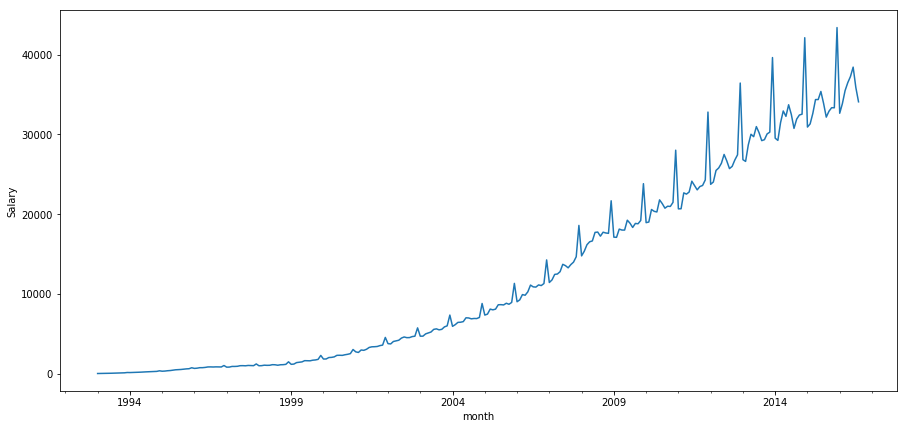

In [12]:
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
plt.ylabel('Salary')
pylab.show()

В данных невооружённым взглядом заметны тренд, сезонность и рост дисперсии со временем.
Ряд нестационарен.

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

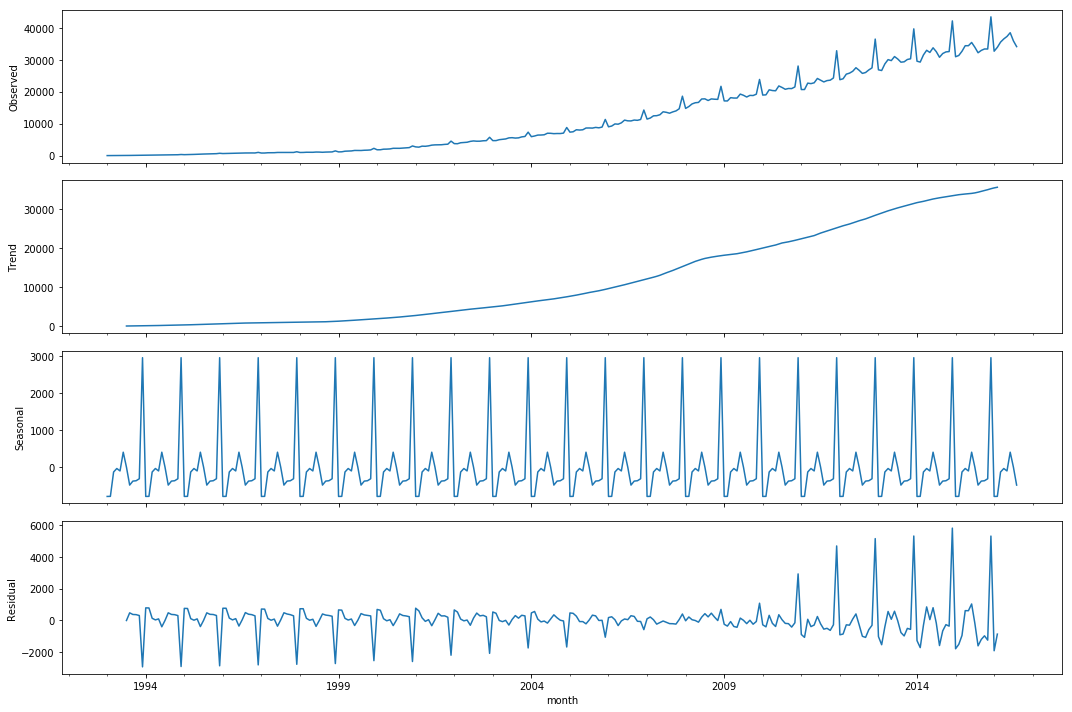

In [15]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M)[1])

##### 2. Преобразования ряда

Для начала применим преобразование Бокса-Кокса и посмотрим, удалось ли стабилизировать дисперсию.

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


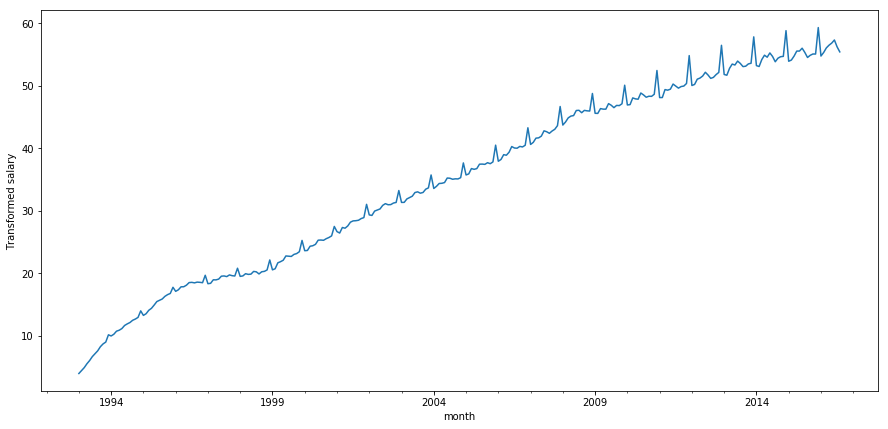

In [16]:
data['salary_box'], lmbda = stats.boxcox(data.WAG_C_M)
plt.figure(figsize(15,7))
data.salary_box.plot()
plt.ylabel(u'Transformed salary')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.salary_box)[1])

Рост дисперсии уменьшился, но всё равно заметен.

Применим к ряду сезонное дифференцирование.

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

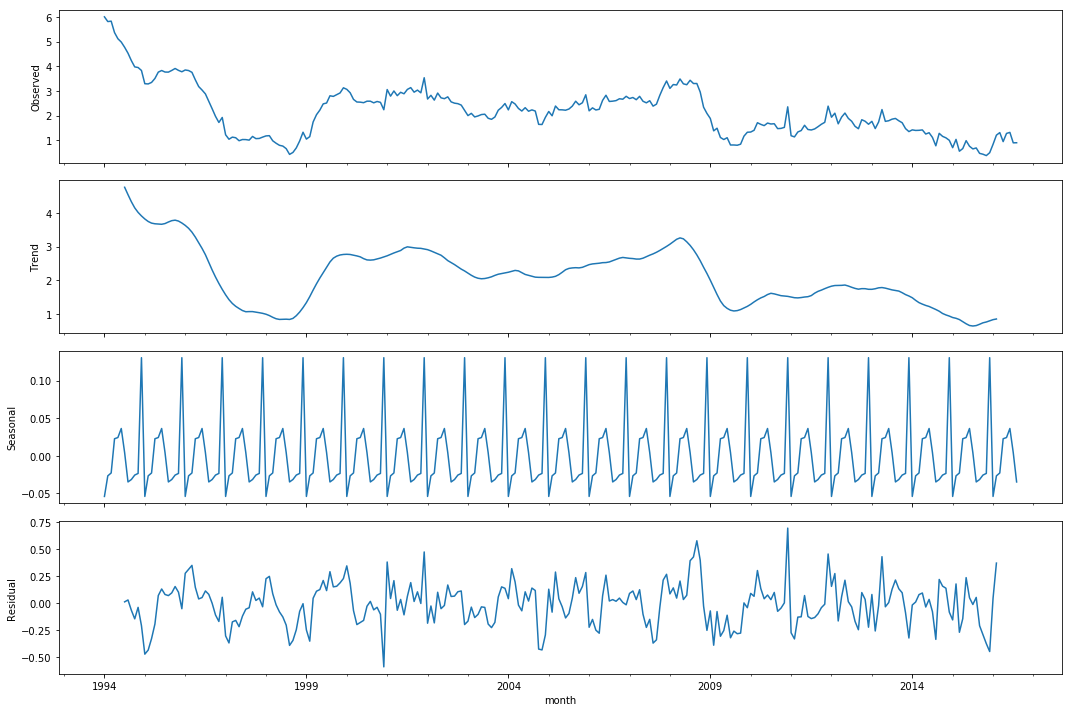

In [17]:
data['salary_box_diff'] = data.salary_box - data.salary_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.salary_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.salary_box_diff[12:])[1])

Несмотря на то что критерий Дики-Фуллера опровергает гипотезу нестационарности на уровне значимости 0.05, в ряде всё же остаётся заметный тренд, что даёт основания всё же не считать этот ряд стационарным.
Попробуем применить обычное дифференцирование.

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

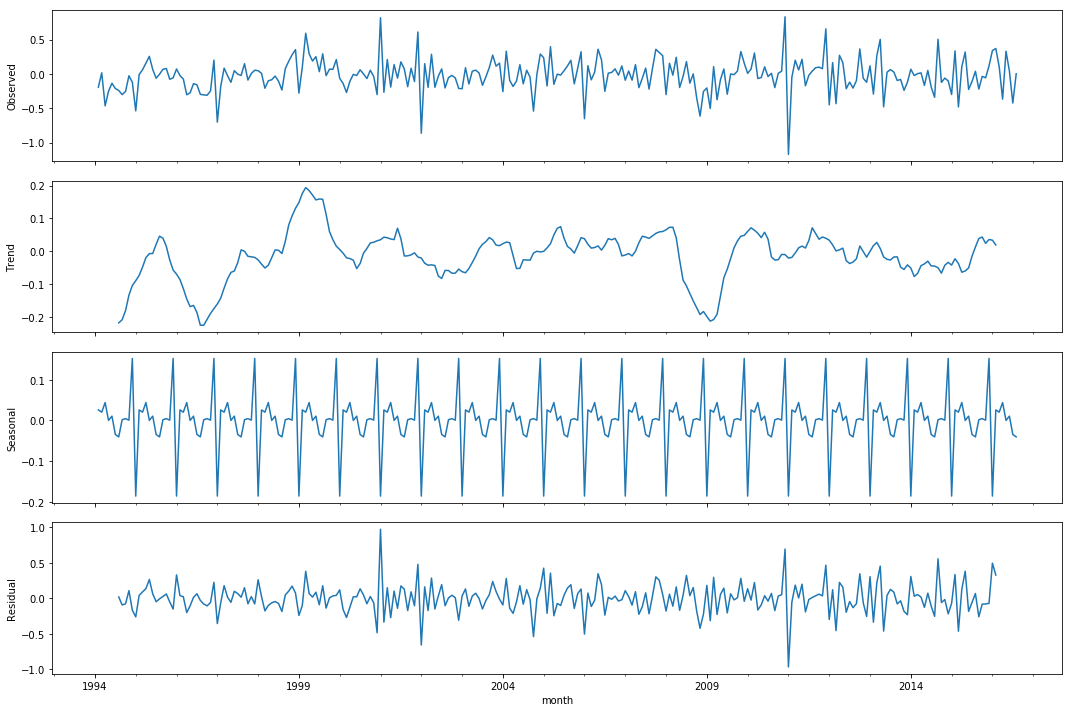

In [18]:
data['salary_box_diff2'] = data.salary_box_diff - data.salary_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.salary_box_diff2[13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.salary_box_diff2[13:])[1])

##### 3. Выбор начальных приближений для гиперпараметров q, Q, p, P

Строим графики автокорреляции и частичной автокорреляции.

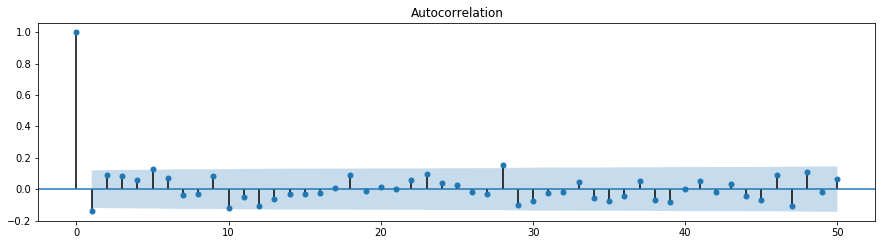

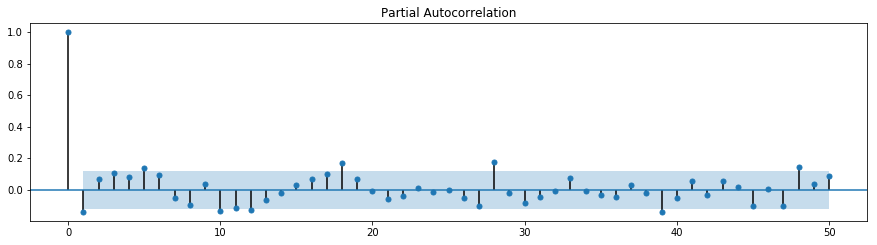

In [35]:
plt.figure(figsize(15,8))
ax = plt.subplot(2,1,1)
sm.graphics.tsa.plot_acf(data.salary_box_diff2[13:].values.squeeze(), lags=50, ax=ax)
pylab.show()
ax = plt.subplot(2,1,2)
sm.graphics.tsa.plot_pacf(data.salary_box_diff2[13:].values.squeeze(), lags=50, ax=ax)
pylab.show()

Q = 0, т.к. на графике автокорреляции нет значимых сезонных отличий от 0.

q=1. На графике автокорреляции есть значимо отличный от 0 лаг с номером 28, но такой параметр делает модель слишком сложной, кроме того этот результат может получаться вследствие множественной проверки гипотез.

P=1. На графике частичной автокорреляции есть значимо отличный от 0 лаг 48 (4-й сезонный). Его не берём по аналогичным основаниям.

p=1.

Зафиксируем набор параметров для перебора.

In [47]:
ps = range(0, 3)
d=1
qs = range(0, 4)
Ps = range(0, 3)
D=1
Qs = range(0, 3)

In [53]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

108

##### 4. Обучение и выбор модели

In [49]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.salary_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (1, 2, 0, 0)
wrong parameters: (1, 2, 0, 1)
wrong parameters: (1, 2, 0, 2)
wrong parameters: (1, 2, 1, 0)
wrong parameters: (1, 2, 1, 1)
wrong parameters: (1, 2, 1, 2)
wrong parameters: (1, 2, 2, 0)
wrong parameters: (1, 2, 2, 1)
wrong parameters: (1, 2, 2, 2)
wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 0, 1)
wrong parameters: (2, 1, 0, 2)
wrong parameters: (2, 1, 1, 0)
wrong parameters: (2, 1, 1, 1)
wrong parameters: (2, 1, 1, 2)
wrong parameters: (2, 1, 2, 0)
wrong parameters: (2, 1, 2, 1)
wrong parameters: (2, 1, 2, 2)
wrong parameters: (2, 2, 0, 0)
wrong parameters: (2, 2, 0, 1)
wrong parameters: (2, 2, 0, 2)
wrong parameters: (2, 2, 1, 0)
wrong parameters: (2, 2, 1, 1)
wrong parameters: (2, 2, 1, 2)
wrong parameters: (2, 2, 2, 0)
wrong parameters: (2, 2, 2, 1)
wrong parameters: (2, 2, 2, 2)


In [50]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters        aic
80  (2, 3, 2, 2) -22.008134
77  (2, 3, 1, 2) -21.603655
72  (2, 3, 0, 0) -21.091488
75  (2, 3, 1, 0) -20.398611
73  (2, 3, 0, 1) -20.140413


Сначала меня смутило отрицательное значение критерия Акаике, но беглый гуглёж показал, что [всё в порядке](https://tolstoy.newcastle.edu.au/R/help/05/04/2614.html).


##### 5. Обзор построенной модели

In [51]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         salary_box   No. Observations:                  284
Model:             SARIMAX(2, 1, 3)x(2, 1, 2, 12)   Log Likelihood                  21.004
Date:                            Sun, 24 Feb 2019   AIC                            -22.008
Time:                                    09:36:17   BIC                             14.013
Sample:                                01-01-1993   HQIC                            -7.545
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5747      0.053     29.529      0.000       1.470       1.679
ar.L2         -0.7701      0.049   

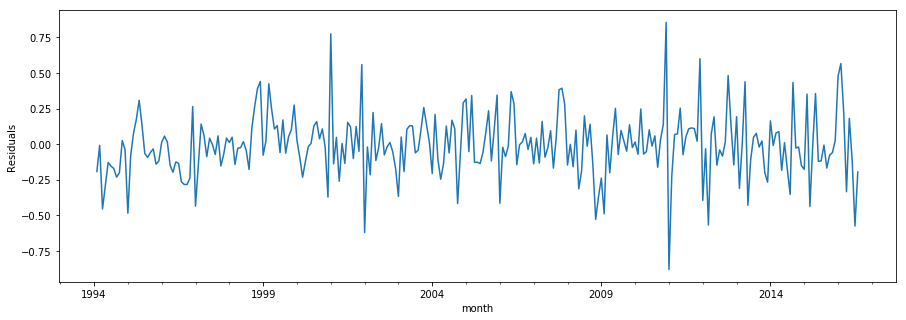

In [75]:
plt.figure(figsize(15,5))
plt.subplot(111)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
pylab.show()

In [82]:
print (np.mean(best_model.resid[13:]))

-0.009495495720281206


In [81]:
print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])

Критерий Стьюдента: p=0.485535


Остатки несмещены.

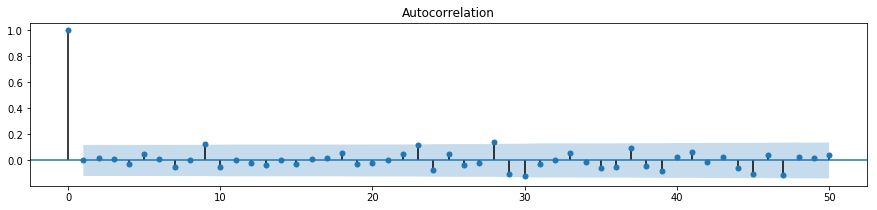

In [71]:
plt.figure(figsize(15,3))
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=50, ax=plt.subplot(111))
pylab.show()

In [83]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Критерий Дики-Фуллера: p=0.000000


Остатки стационарны и неавтокоррелированы.

Посмотрим на графики модельных и истиных данных.

In [84]:
# Обратное преобразование Бокса-Кокса к данным, выдаваемым моделью
data['model'] = invboxcox(best_model.fittedvalues, lmbda)

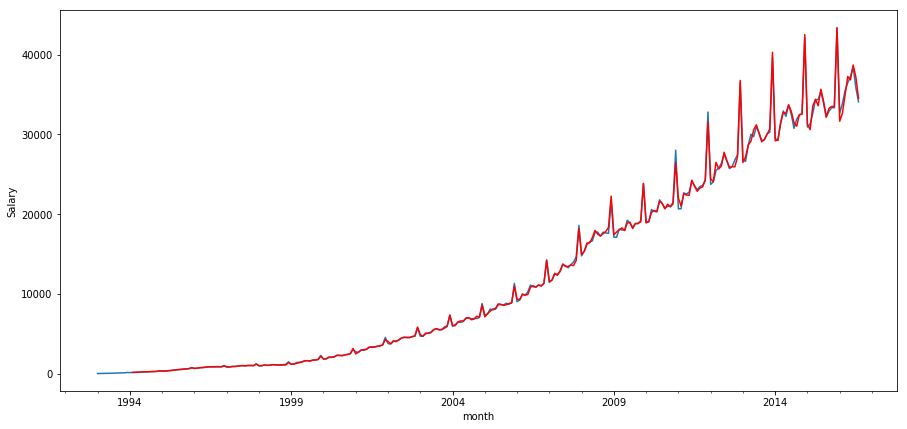

In [85]:
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
data.model[13:].plot(color='r')
plt.ylabel('Salary')
pylab.show()

##### 6. Прогноз

In [88]:
start = data.shape[0]

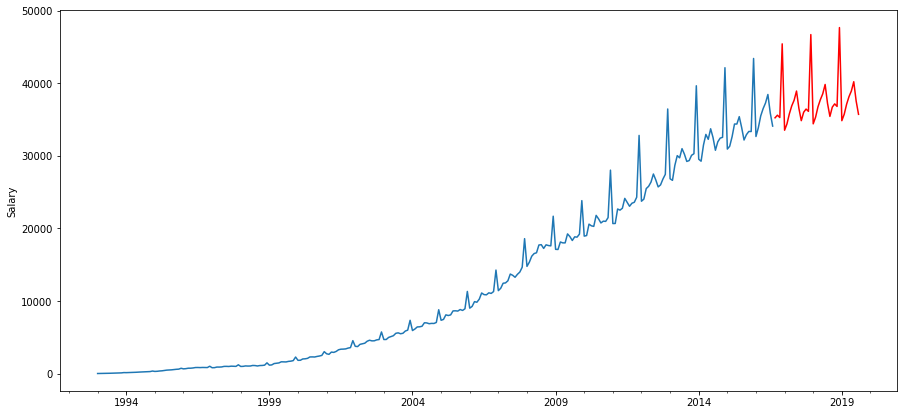

In [89]:
data2 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns=data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=start, end=start+36), lmbda)

plt.figure(figsize(15,7))
data2.WAG_C_M.plot()
data2.forecast.plot(color='r')
plt.ylabel('Salary')
pylab.show()

In [92]:
data2.forecast.tail(36)

2016-09-01    35234.114646
2016-10-01    35595.351580
2016-11-01    35272.144495
2016-12-01    45423.094723
2017-01-01    33523.297116
2017-02-01    34402.587016
2017-03-01    35783.976246
2017-04-01    36876.206370
2017-05-01    37659.327795
2017-06-01    38923.226036
2017-07-01    36535.063043
2017-08-01    34841.822983
2017-09-01    36002.516653
2017-10-01    36439.050889
2017-11-01    36125.213723
2017-12-01    46699.520593
2018-01-01    34405.058516
2018-02-01    35329.193585
2018-03-01    36751.947871
2018-04-01    37735.814018
2018-05-01    38539.510077
2018-06-01    39828.179646
2018-07-01    37222.444621
2018-08-01    35429.063275
2018-09-01    36705.272889
2018-10-01    37152.118606
2018-11-01    36801.794384
2018-12-01    47663.930288
2019-01-01    34838.575043
2019-02-01    35724.483348
2019-03-01    37102.643145
2019-04-01    38147.973125
2019-05-01    38933.307278
2019-06-01    40205.173448
2019-07-01    37554.616848
2019-08-01    35715.536137
Name: forecast, dtype: float